<a href="https://colab.research.google.com/github/gogzicole/Hamoye-Data-science/blob/master/Stage_E_Quiz_Notebook_chigozie_mbonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from numpy import nan
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import isnan

**The Dataset for this quiz notebook is a multivariate time series data of power consumption of a household sampled at a one minute time priod.**

**The Initial part of the notebook is the Data loading and pre-processing parts which includes but is not limited to:**

1. Loading the Dataset, dealing with the null values by filling them with the data at the same time of the previos year with non missing values, or with the mean of the respective column.

2. Resampling the Data from a minute time frame to a daily time frame.

3. Defining a function(ADF-test) that takes the dataset and checks for stationarity of the series (if series is non stationary the data would be made stationary by log differencing method).

4. confirm the output of the series test function, by plotting the mean and standard deviation on the same plot with the data, to see if there is a change in the mean or std over time.

5. finally the data is ready to be used for building a model, and for analysis.

NOTE :
Due to the large size of the unzipped dataset, the data was stored in compressed zip file and was uploaded to my google drive, and was loaded directly by using the mount drive method on colab.

**After the data preprocessing and test blocks, the codes used in answering the quiz question follows, and are labelled in the order in which they appear**




In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file = zipfile.ZipFile('/content/drive/My Drive/household_power_consumption.zip', 'r') #this code loads the zipped dataset from drive 
file.extractall('tmp') #this code extracts the ext file from the loaded zip file to directory tmp on colab

In [298]:
#loading the dataset
df = pd.read_csv('/content/tmp/household_power_consumption.txt', sep=';',
                 na_values = '?',dtype = float ,low_memory=False,infer_datetime_format=True,
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [232]:
#check for missing values
print(df.shape)
df.isnull().sum()

(2075259, 7)


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [299]:
#filling missing values with data from the same day of the previous year
def fill_missing(values):
  one_day = 60 *24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row,col]):
        values[row, col] = values[row - one_day, col]

In [300]:
#ALTERNATE 1
#calling the fillna funcion on dataset
fill_missing(df.values)

In [303]:
#ALTERNATE 2
#filling the missing values with the mean
df2 = df.fillna(df.mean())

In [8]:
#print(df.isnull().sum())
print(df2.isnull().sum())
#df.head()
df2.head()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# add a column for for the remainder of sub metering
#values = df.values.astype('float32')
#df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

**as we can see the dataset has a very huge amount of rows and this is due to the fact that the samples were collected every munite for five years, dealing with this data directly would be computationally expensive, so we would be breaking the dataset into various sample sizes(hourly, daily, weekly, and monthly).**

**Resampling (undersampling the time series data)**

In [304]:
#daily resampling
daily_df = df2.resample('D').sum()
print(daily_df.shape)
daily_df.head(3)



(1442, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


**Now, i will carry out an augmented dickey fuller test on the various sample sizes to check for the stationarity of the series. A stationary series is one whose mean and variance do not change with time.**

**ADF test for stationarity**

the ADF test generates a tuple made of six parameters, the ADF-test statistics, P-value, number of lags used, number of observation used, critical values at 1%, 5%, 10% and the maximized information criterion.

we would be looking at the first five values using the P-value to determine if the series is stationary, wher P-value< 0.05.

In [ ]:
# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.stattools import adfuller

#since we have several samples of time series lets define a function that could check for
#stationarity and output the various columns that are stationary in the series.

def adf_test(d_set):
    dftest = adfuller(d_set, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")
      
#this function takes a time series datframe and checks the columns that are stationary.
def get_stationarity(data):
    for i in data.columns:
        print("Column: ",i)
        print('--------------------------------------')
        adf_test(data[i])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
get_stationarity(daily_df) #calling the function to test for stationarity

Column:  Global_active_power
--------------------------------------
Test Statistic            -3.731704
p-value                    0.003689
# Lags                    22.000000
# Observations          1419.000000
Critical Value (1%)       -3.434967
Critical Value (5%)       -2.863579
Critical Value (10%)      -2.567856
dtype: float64

Series is Stationary
Column:  Global_reactive_power
--------------------------------------
Test Statistic            -3.825851
p-value                    0.002654
# Lags                    22.000000
# Observations          1419.000000
Critical Value (1%)       -3.434967
Critical Value (5%)       -2.863579
Critical Value (10%)      -2.567856
dtype: float64

Series is Stationary
Column:  Voltage
--------------------------------------
Test Statistic            -2.959237
p-value                    0.038881
# Lags                    23.000000
# Observations          1418.000000
Critical Value (1%)       -3.434970
Critical Value (5%)       -2.863580
Critical Val

form the ADF test performed from all the resampled time frame we can see that

1. all the columns in DAILY_DF are stationary


**Visualizing the stationary series**

for refrence sake i would be visualizing the stationary parts of monthly_df and the non stationary columns so we can make comparison between a stationary and non stationary plot.

In [ ]:
rolling_mean = daily_df.rolling(window = 365).mean()
rolling_std = daily_df.rolling(window = 365).std()

Text(0, 0.5, 'Sub metering 1')

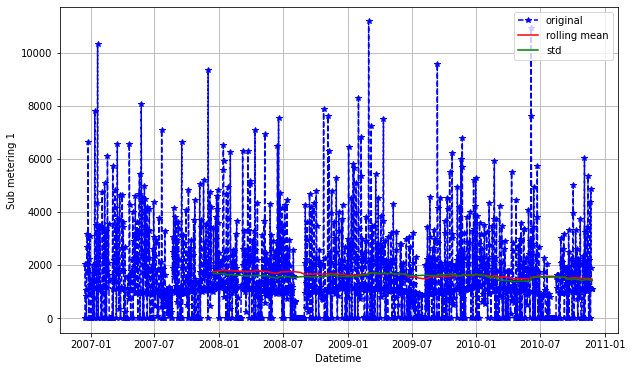

In [ ]:
# SUB METERING 1 OF THE DAILY_DF
plt.figure(figsize=(10,6))
original = plt.plot(daily_df.index, daily_df.Sub_metering_1,'--', marker='*', color = 'blue',label = 'original')
mean = plt.plot(rolling_mean.index, rolling_mean.Sub_metering_1, color = 'red',label = 'rolling mean')
std = plt.plot(rolling_std.index, rolling_std.Sub_metering_1, color = 'green', label = 'std')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Sub metering 1')
# you can see that there is no obvious trend or seasonality in the plot.
# Also the mean and the Standard Deviation are constant, which supports the stationarity of the series


Text(0, 0.5, 'Global active power')

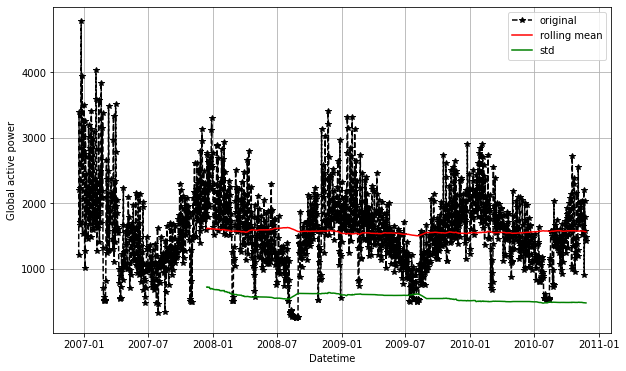

In [ ]:
# GLOBAL ACTIVE POWER OF THE DAILY_DF
plt.figure(figsize=(10,6))
original = plt.plot(daily_df.index, daily_df.Global_active_power,'--', marker='*', color = 'black',label = 'original')
mean = plt.plot(rolling_mean.index, rolling_mean.Global_active_power, color = 'red',label = 'rolling mean')
std = plt.plot(rolling_std.index, rolling_std.Global_active_power, color = 'green', label = 'std')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global active power')
# There is no trend or seasonality in the Global active power from the plot.
# The mean and std are also constant.


Text(0, 0.5, 'Global Reactive Power')

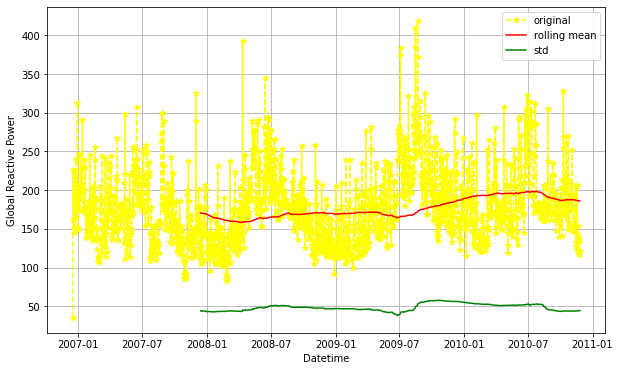

In [ ]:
# GLOBAL_REACTIVE_POWER
plt.figure(figsize=(10,6))
original = plt.plot(daily_df.index, daily_df.Global_reactive_power,'--', marker='*', color = 'yellow',label = 'original')
mean = plt.plot(rolling_mean.index, rolling_mean.Global_reactive_power, color = 'red',label = 'rolling mean')
std = plt.plot(rolling_std.index, rolling_std.Global_reactive_power, color = 'green', label = 'std')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global Reactive Power')

Text(0, 0.5, 'Sub metering 2')

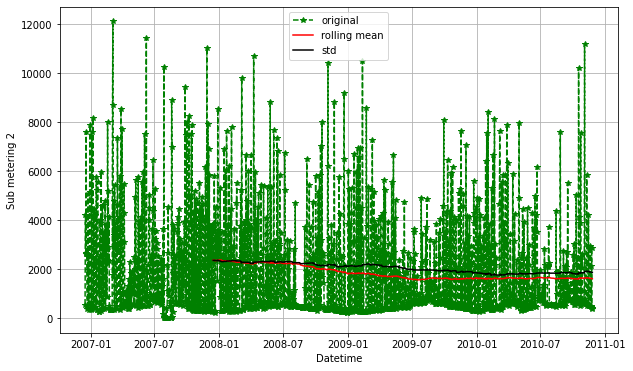

In [ ]:
#SUB METERING 2
plt.figure(figsize=(10,6))
original = plt.plot(daily_df.index, daily_df.Sub_metering_2,'--', marker='*', color = 'green',label = 'original')
mean = plt.plot(rolling_mean.index, rolling_mean.Sub_metering_2, color = 'red',label = 'rolling mean')
std = plt.plot(rolling_std.index, rolling_std.Sub_metering_2, color = 'black', label = 'std')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Sub metering 2')

Text(0, 0.5, 'Global_intensity')

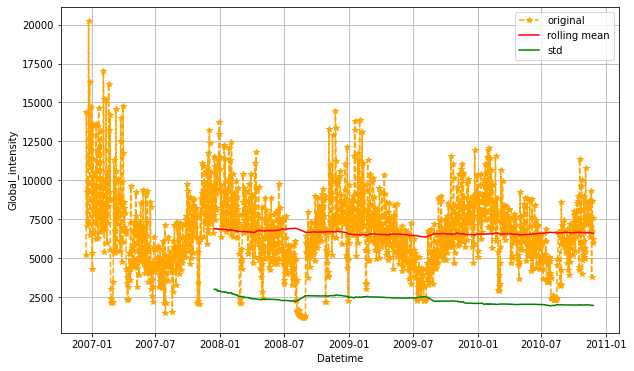

In [ ]:
# GLOBAL INTENSITY
plt.figure(figsize=(10,6))
original = plt.plot(daily_df.index, daily_df.Global_intensity,'--', marker='*', color = 'orange',label = 'original')
mean = plt.plot(rolling_mean.index, rolling_mean.Global_intensity, color = 'red',label = 'rolling mean')
std = plt.plot(rolling_std.index, rolling_std.Global_intensity, color = 'green', label = 'std')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Datetime')
plt.ylabel('Global_intensity')

to create a model with the dataset we have to first convert the non-stationary columns to stationary as most of the libraries used in creating time series forecast models assume stationarity.

**Question. 11**

Text(0, 0.5, 'global active power')

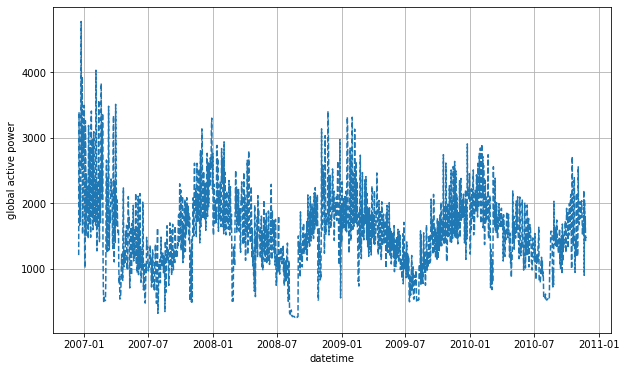

In [119]:
#plot of global active power on th daily time frame
plt.figure(figsize=(10,6))
plt.plot(daily_df.index, daily_df.Global_active_power,'--')
plt.grid()
plt.xlabel('datetime')
plt.ylabel('global active power')

**Question. 12**

In [ ]:
from scipy.stats import pearsonr
pearsonr(df2['Global_active_power'],df2['Global_reactive_power'])

**Question. 13**

In [307]:
from scipy.stats import pearsonr
pearsonr(df2['Voltage'],df2['Global_intensity'])


**Creating Models**

for the modeling part i would be creating a facebook prophet model to forecast the global active power as the target univariate data.

**FB prophet Model**

In [118]:
from fbprophet import Prophet

prophet model works only on univariate data, so we would have to make individual forecasts on the data set by selecting a column and the time stamp

**Univariate Model**

**Question. 14**

( MAPE)



In [179]:
#we have to reset the datetime index and assign it as a column in the new dataframe
daily_df.reset_index(inplace=True)
#next we take a slice of the Dataframe columns that would be used to build the prophet model and assign it to a variable
prophet_daily = daily_df[['datetime','Global_active_power']]


prophet does not understand the column names as it is, so we have to rename the datetime column as ds and the target variable as y

In [180]:
#renaming the columns 
prophet_daily = prophet_daily.rename(columns = {'datetime': 'ds','Global_active_power': 'y'})
print(prophet_daily.shape)
prophet_daily.head()


(1442, 2)


,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [181]:
train_set = prophet_daily.iloc[:1077,:]
test_set = prophet_daily.iloc[1077:,:]
print(train_set.shape)
print(test_set.shape)

(1077, 2)
(365, 2)


In [182]:
#fitting the model to the dataset
p_model = Prophet()
p_model.fit(train_set)
pred = p_model.predict(test_set)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [127]:
# Define a model for the calculation of MAPE
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

In [184]:
mape = Metric(test_set['y'],pred['yhat'])
print(f'the Mean Average Percentage Error ( MAPE) is:{round(mape,1)}')

the Mean Average Percentage Error ( MAPE) is:20.9


**Question. 15**

( RMSE)

In [185]:
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test_set['y']),np.array(pred['yhat'])))
print('The Root Mean Square Error(rmse) value is : %s' %(round(rmse,1)))

The Root Mean Square Error(rmse) value is : 375.0


**Question. 16**

Figure(648x648)


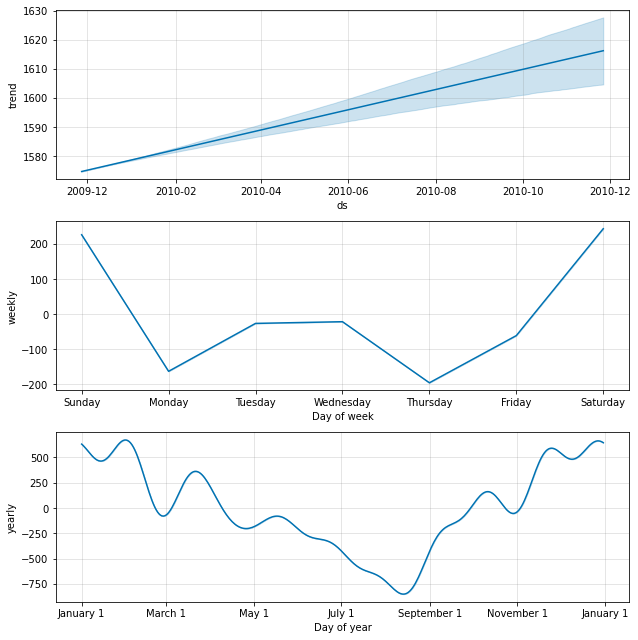

In [148]:
print(p_model.plot_components(pred))
# from the plot of yearly seasonality AUGUST has the lowest value.

**Multivariate Model**

**Question. 17**

( MAPE)

In [187]:
# reseting the index column of the daily_df
daily_df.reset_index(inplace = True)
multi_prophet = daily_df
print(multi_prophet.shape)
multi_prophet.head()


(1442, 8)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [188]:
# Renaming the columns to prophet name format
multi_prophet = multi_prophet.rename(columns = {'datetime':'ds','Global_active_power':'y','Global_reactive_power':'add1',
                                                'Voltage':'add2','Global_intensity':'add3','Sub_metering_1':'add4',
                                                'Sub_metering_2':'add5','Sub_metering_3':'add6'})

In [189]:
#checking the renamed dataframe
multi_prophet.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [190]:
train_set_multi = multi_prophet.iloc[:1077,:]
test_set_multi = multi_prophet.iloc[1077:,:]
print(train_set_multi.shape)
print(test_set_multi.shape)

(1077, 8)
(365, 8)


In [191]:
# Creating the prophet multivariate model
m_model = Prophet()
m_model.add_regressor('add1')
m_model.add_regressor('add2')
m_model.add_regressor('add3')
m_model.add_regressor('add4')
m_model.add_regressor('add5')
m_model.add_regressor('add6')

In [192]:
# Fitting the model to train set
m_model.fit(train_set_multi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [193]:
# Making prediction with test_set
m_pred = m_model.predict(test_set_multi)

In [196]:
# calculating the MAPE using the previously defined function
mape = Metric(test_set_multi['y'],m_pred['yhat'])
print('The Mean Average Percentage Error ( MAPE) Is:%s' %round(mape,2))

The Mean Average Percentage Error ( MAPE) Is:2.63


**Question. 18**

( RMSE)

In [197]:
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test_set_multi['y']),np.array(m_pred['yhat'])))
print('The Root Mean Square Error(rmse) Value Is : {}'.format(round(rmse,2)))

The Root Mean Square Error(rmse) Value Is : 39.13


**Question. 19**

Figure(648x864)


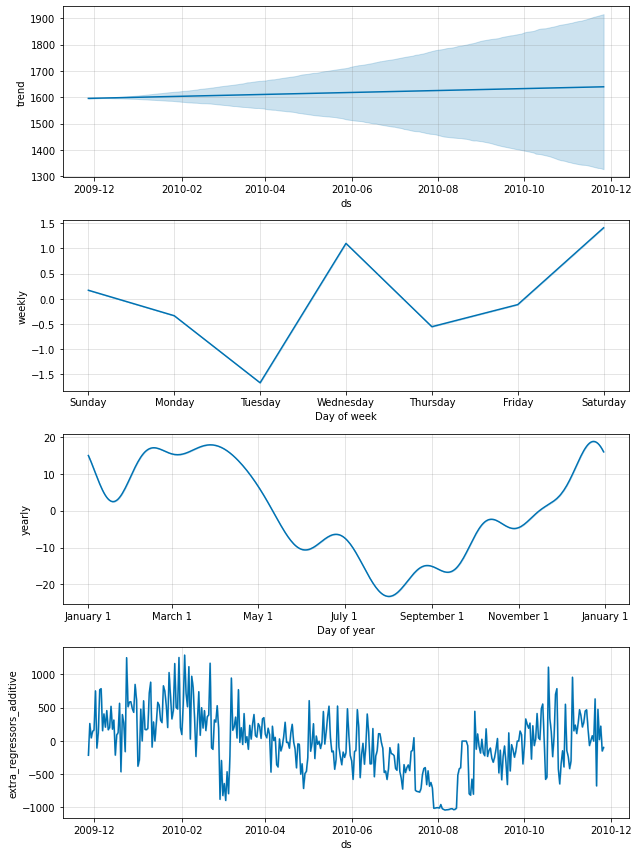

In [198]:
print(m_model.plot_components(m_pred))
#from the plot of the weekly multivariate forecasted model , TUESDAY has the lowest value